# Setting the Scene

In [ ]:
#Updating matplotlib to utilize a new function later on
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 20.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [ ]:
%%capture
!pip install -U tensorflow
!pip install -U tensorflow-gpu
!pip install -U tensorflow-addons
!pip install -U keras-tuner

In [ ]:
# Importing the appropriate libraries
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from tqdm.notebook import tqdm
from collections import  Counter

from textblob import TextBlob
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import re, os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, precision_recall_curve, auc, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_files   
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Downloading Data
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
!tar xvzf review_polarity.tar.gz

--2023-03-03 08:15:15--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  1.87MB/s    in 1.6s    

2023-03-03 08:15:18 (1.87 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]

txt_sentoken/neg/cv000_29416.txt
txt_sentoken/neg/cv001_19502.txt
txt_sentoken/neg/cv002_17424.txt
txt_sentoken/neg/cv003_12683.txt
txt_sentoken/neg/cv004_12641.txt
txt_sentoken/neg/cv005_29357.txt
txt_sentoken/neg/cv006_17022.txt
txt_sentoken/neg/cv007_4992.txt
txt_sentoken/neg/cv008_29326.txt
txt_sentoken/neg/cv009_29417.txt
txt_sentoken/neg/cv010_29063.txt
txt_sentoken/neg/cv011_13044.txt
txt_sentoken/neg/cv012_29411.txt
txt_sentoken/neg/cv0

In [ ]:
#Loading the files
movies = load_files(container_path="txt_sentoken", encoding="utf-8")  
x, y = movies.data, movies.target

In [ ]:
# Preprocessing of the data for the Exploratory data analysis
lemmatizer = WordNetLemmatizer()
docs = []

for doc in tqdm(x):
    # Remove non-word (special) characters such as punctuation etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
      
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Lemmatization
    document = [lemmatizer.lemmatize(word) for word in document]
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)

  0%|          | 0/2000 [00:00<?, ?it/s]

# Exploratory Data Analysis

In [ ]:
docs_len=[] #storing the length of each text
for i in range(len(docs)):
   x=len(docs[i])
   docs_len.append(x)
print('The average document length is:',int(st.mean(docs_len)),'(characters).') #computing the average document length
print('The standard deviation of document legth is:',int(st.stdev(docs_len)),'(characters).') #computing the standard deviation of document length
print('The minimum document legth is:',int(min(docs_len)),'(characters).')
print('The maximum document legth is:',int(max(docs_len)),'(characters).')

The average document length is: 3528 (characters).
The standard deviation of document legth is: 1559 (characters).
The minimum document legth is: 84 (characters).
The maximum document legth is: 13745 (characters).


In [ ]:
# Create a dataframe
df=pd.DataFrame(docs,columns=['Document']) 
df['Target']=  movies.target
df

,Document,Target
0,arnold schwarzenegger ha been an icon for acti...,0
1,good film are hard to find these day great fil...,1
2,quaid star a man who ha taken up the proffesio...,1
3,we could paraphrase michelle pfieffer characte...,0
4,kolya is one of the richest film ve seen in so...,1
...,...,...
1995,under any other circumstance would not be disc...,0
1996,bruce barth mellow piano play in the backgroun...,1
1997,man is not man without eight tael of gold star...,1
1998,this is film that wa inclined to like at the o...,0


In [ ]:
df.duplicated().value_counts() #there are duplicates present

False    1998
True        2
dtype: int64

In [ ]:
df = df.drop_duplicates() #dropping the duplicates

Polarity shows the sentiment of a piece of text. It counts the negative and positive words and determines the polarity. The value ranges from -1 to 1 where -1 represents the negative sentiment, 0 represents neutral and 1 represent positive sentiment.

In [ ]:
df['polarity'] = df['Document'].map(lambda text: TextBlob(text).sentiment.polarity)
df.sort_values('polarity')

<ipython-input-10-6287655d61c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['Document'].map(lambda text: TextBlob(text).sentiment.polarity)


,Document,Target,polarity
1412,can horror movie truly be called horror movie ...,0,-0.291174
1690,susan granger review of jeepers creeper mgm ua...,0,-0.285193
1856,i never understood what the clich hell on eart...,0,-0.243867
652,plot token director alan smithee steal the onl...,0,-0.210807
1636,i think we should a responsible citizen all ge...,0,-0.208900
...,...,...,...
848,i had been expecting more of this movie than t...,1,0.329592
760,it is an understood passion and an understood ...,1,0.333543
114,don let the following quirk of this review foo...,1,0.342132
779,one of the sweetest tale to ever be made it a ...,1,0.362966


In [ ]:
# source: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:100]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x) 

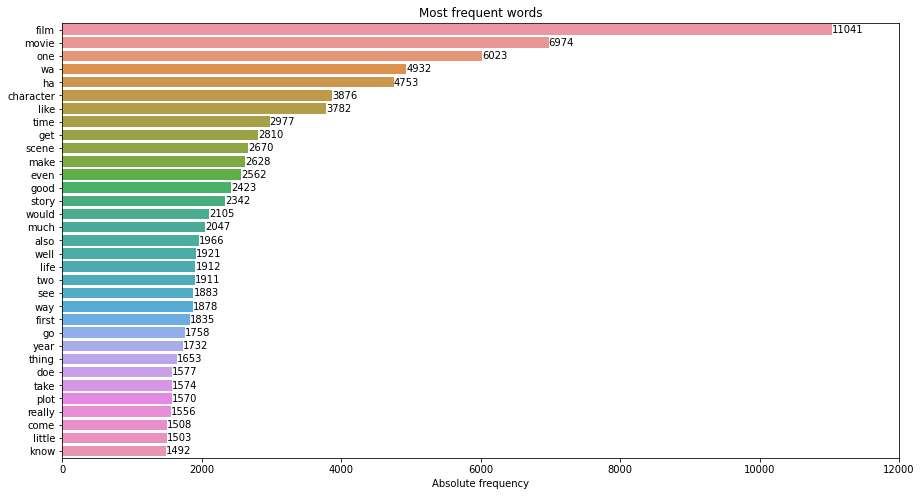

In [ ]:
# Plot of the most frequent words
fig,ax = plt.subplots(figsize=(15,8))
plot_top_non_stopwords_barchart(df['Document'])
_ = ax.set_title('Most frequent words')
_ = ax.set_xlabel('Absolute frequency')
_ = ax.set_xlim(0,12000)
ax.bar_label(ax.containers[0])
plt.box('False')
plt.savefig('EDA_1.png')

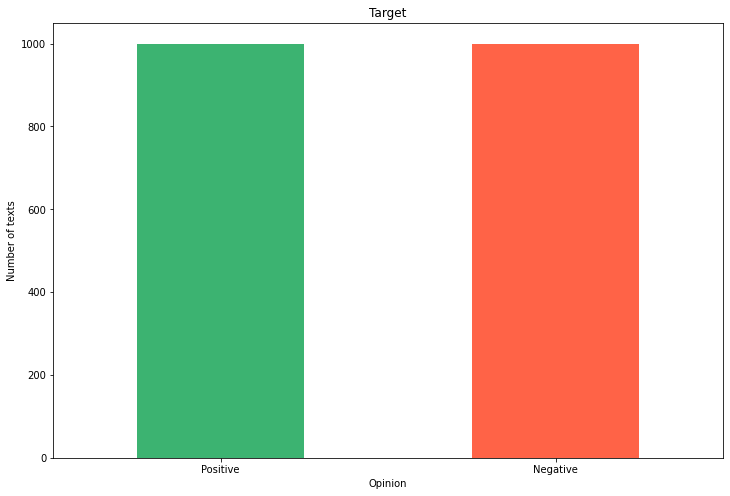

In [ ]:
# Plot of the categories of the target variable
df['Target'].value_counts().plot(kind='bar',color=['mediumseagreen','tomato'], figsize=(12,8))
plt.title('Target')
plt.ylabel('Number of texts')
plt.xlabel('Opinion')
plt.xticks([1,0],['Negative','Positive'],rotation=0)
plt.savefig("EDA_2.png")

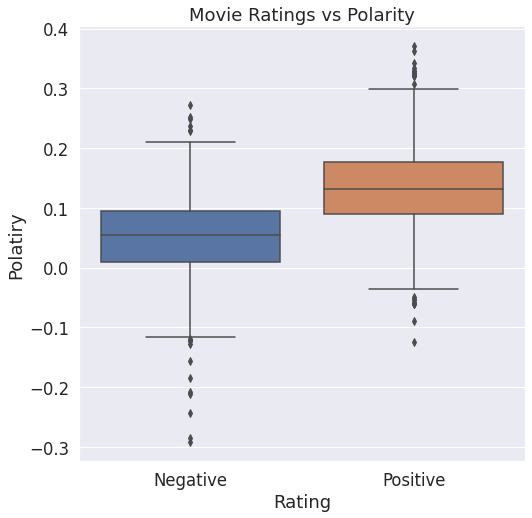

In [ ]:
# Boxplot
# source: https://regenerativetoday.com/exploratory-data-analysis-of-text-data-including-visualization-and-sentiment-analysis/
plt.figure(figsize = (8, 8))
sns.set(font_scale = 1.5)
sns.boxplot(x = 'Target', y = 'polarity', data = df)
plt.xlabel("Rating")
plt.ylabel("Polatiry")
plt.title("Movie Ratings vs Polarity")
plt.xticks([0,1],['Negative','Positive'],rotation=0)
plt.savefig("EDA_3.png")

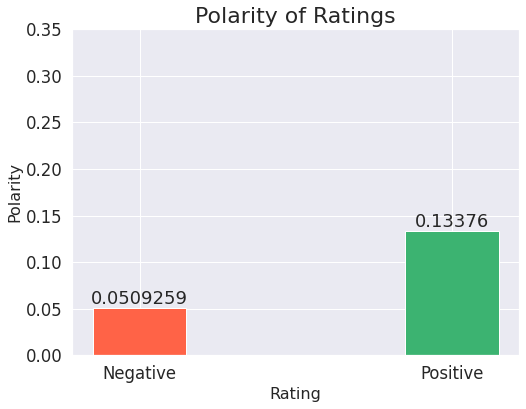

In [ ]:
#source: https://regenerativetoday.com/exploratory-data-analysis-of-text-data-including-visualization-and-sentiment-analysis/
mean_pol = df.groupby('Target')['polarity'].agg([np.mean])
mean_pol.columns = ['mean_polarity']
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(mean_pol.index, mean_pol.mean_polarity, width=0.3, color=['tomato','mediumseagreen'])
'''for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+0.01, str("{:.2f}".format(i.get_height())))'''
ax.bar_label(ax.containers[0])
plt.xticks([0,1],['Negative','Positive'],rotation=0)
plt.title("Polarity of Ratings", fontsize=22)
plt.ylabel("Polarity", fontsize=16)
plt.xlabel("Rating", fontsize=16)
plt.ylim(0, 0.35)
plt.savefig("EDA_4.png")

Getting the most common n-grams of the corpus:

In [ ]:
#Most common n-grams
def get_top_n_bigram(corpus,i, n=None):
  if i==1:  
    vec = CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

  elif i==2:
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
  elif i==3:
    vec = CountVectorizer(ngram_range=(3,3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

  return words_freq[:n]

In [ ]:
# Most common Bigrams
common_words = get_top_n_bigram(df['Document'] ,2, len(df))
df1 = pd.DataFrame(common_words, columns=['Bigram', "Count"])
df1.head(10)

,Bigram,Count
0,of the,8770
1,in the,5799
2,the film,4589
3,to the,2782
4,to be,2740
5,and the,2546
6,on the,2253
7,the movie,2240
8,with the,1899
9,for the,1892


In [ ]:
# Most common trigrams
common_words = get_top_n_bigram(df['Document'],3, len(df))
df2 = pd.DataFrame(common_words, columns=['Trigram', "Count"])
df2.head(10)

,Trigram,Count
0,one of the,1027
1,of the film,890
2,in the film,590
3,the film is,544
4,of the movie,379
5,some of the,363
6,the rest of,350
7,the fact that,308
8,most of the,293
9,in this film,289


# Models


## Data Preproccecing

Splitting data to train, test , validation:

In [ ]:
from sklearn.model_selection import train_test_split  
#getting the validation subset
X_train, X_val, y_train, y_val = train_test_split(movies.data, 
                                                  movies.target, 
                                                  test_size=0.10, 
                                                  random_state=12547392)
#getting the train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train,
                                                    test_size=0.111,
                                                    random_state=12547392)

In [ ]:
print('The length of the train set is: ',len(X_train),"texts\nThe length of the validation set is:", len(X_val),"texts\nThe length of the test set is:", len(X_test),"texts")

The length of the train set is:  1600 texts
The length of the validation set is: 200 texts
The length of the test set is: 200 texts


In [ ]:
# Tokenization of the data
import spacy
import string

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser","ner"])
from spacy.lang.en.stop_words import STOP_WORDS
nlp.add_pipe('sentencizer') 

X_train_tokenized = []
for idx in tqdm(range(len(X_train))):
  doc = nlp(X_train[idx])
  tokens = []
  for sent in doc.sents:
    for tok in sent:
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
       tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
        continue
      if tok.text.strip():  
        tokens.append(tok.text.replace('"',"'").strip())
  X_train_tokenized.append(tokens)

X_val_tokenized = []
for idx in tqdm(range(len(X_val))):
  doc = nlp(X_val[idx])
  tokens = []
  for sent in doc.sents:
    for tok in sent:
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
       tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
        continue
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip())
  X_val_tokenized.append(tokens)

X_test_tokenized = []
for idx in tqdm(range(len(X_test))):
  doc = nlp(X_test[idx])
  tokens = []
  for sent in doc.sents:
    for tok in sent:
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
       tok.text.lower() in STOP_WORDS or tok.text in string.punctuation:
        continue
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip())
  X_test_tokenized.append(tokens)

  0%|          | 0/1600 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
#Forming sentences from the tokens

docs_train = []
docs_test = []
docs_val = []
for sentence in X_train_tokenized:
  docs_train.append(' '.join(sentence))
for sentence in X_test_tokenized:
  docs_test.append(' '.join(sentence))
for sentence in X_val_tokenized:
  docs_val.append(' '.join(sentence))

In [ ]:
# Function for the computation of the metrics
def model_tester2(estimator,x_train,y_train,x_val,y_val,x_test,y_test):

  '''
  params: estimator: an already trained pipeline object
          x_train, y_train, x_val, y_val, x_test, y_test: the training and testing data 
  
  output: f1-scores on the training and testing data
          classification reports of the training, validation and testing data
          confusion matrix of the testing data
  '''

  predictions = estimator.predict(x_train)     #making predictions using the pipeline object and the training data
  score = f1_score(y_train, predictions)       #calculating the f1-score of the training data

  print("Train f1-score: {:.2f}%".format(score*100))

  predictions_test = estimator.predict(x_test)    #making predictions using the pipeline object and the testing data
  score = f1_score(y_test, predictions_test)      #calculating the f1-score of the testing data

  print("Test f1-score: {:.2f}% \n".format(score*100))

  predictions_val = estimator.predict(x_val)    #making predictions using the pipeline object and the validation data
  score = f1_score(y_val, predictions_val)      #calculating the f1-score of the validation data

  print("Val f1-score: {:.2f}% \n".format(score*100)) 

  print("\nThe classification report on the Train data:")
  print(classification_report(y_train, predictions))

  print("\nThe Classification report on the Validation data")
  print(classification_report(y_val, predictions_val))

  print("\nThe Classification report on the Test data")
  print(classification_report(y_test, predictions_test))

  print("\nConfusion Matrix for test data:")
  fig, ax = plt.subplots(figsize=(12,8))
  sns.heatmap(confusion_matrix(y_test, predictions_test),annot=True, cmap='mako', fmt='.5g', ax=ax)

## Dummy Classifier

In [ ]:
#creating a pipeling to combine the tfidf vectorizer and the DummyClassifier and train them together
du_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True, 
                                         stop_words=stopwords.words('english'), 
                                         max_features=5000)),
    ('du', DummyClassifier(strategy='most_frequent'))
])

In [ ]:
#fitting the dummy model
du_pipeline.fit(docs_train, y_train)

Train f1-score: 0.00%
Test f1-score: 0.00% 

Val f1-score: 0.00% 


The classification report on the Train data:


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       810
           1       0.00      0.00      0.00       790

    accuracy                           0.51      1600
   macro avg       0.25      0.50      0.34      1600
weighted avg       0.26      0.51      0.34      1600


The Classification report on the Validation data
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       102
           1       0.00      0.00      0.00        98

    accuracy                           0.51       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.26      0.51      0.34       200


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        88
           1       0.00      0.00      0.00       112

    accuracy                           0.44       200
   macro avg       0.22      0.50 

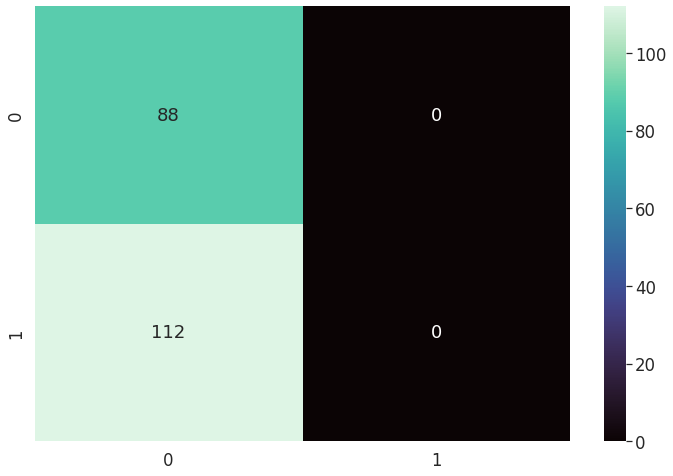

In [ ]:
model_tester2(du_pipeline, docs_train, y_train, docs_val, y_val, docs_test, y_test)

## SVM

In [ ]:
#creating a pipeline to combine the tfidf vectorizer with the SVM Classifier and train them together
svm_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(sublinear_tf=True,
                                         stop_words = stopwords.words('english'),
                                         max_features=5000)),
    ('svm', SVC())])

In [ ]:
#setting the parameters of the previous pipeline to be the best parameters
best_params_= {'svm__C': 1, 'svm__kernel': 'rbf', 'tfidf_vectorizer__ngram_range': (1, 1)} # from assignment2 using GridSearch 
svm_pipeline.set_params(**best_params_)

#training the pipeline
svm_pipeline.fit(docs_train,y_train)

Train f1-score: 99.94%
Test f1-score: 83.78% 

Val f1-score: 83.60% 


The classification report on the Train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       810
           1       1.00      1.00      1.00       790

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


The Classification report on the Validation data
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       102
           1       0.87      0.81      0.84        98

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200


The Classification report on the Test data
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        88
           1       0.85    

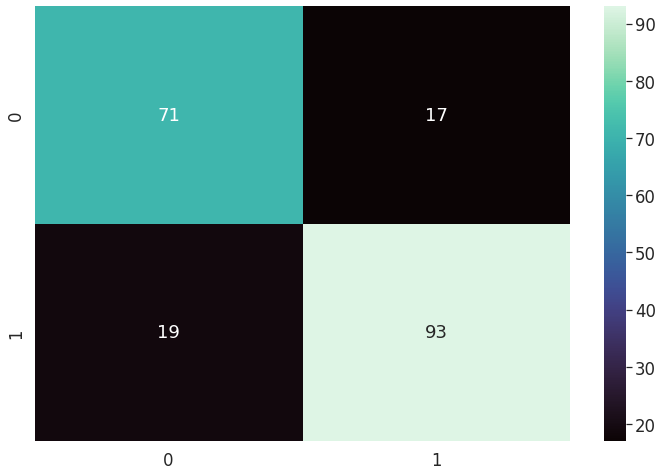

In [ ]:
model_tester2(svm_pipeline, docs_train, y_train, docs_val, y_val, docs_test, y_test)

Precision-Recall curves ( getting the AUC scores ):

In [ ]:
svm_pipeline['svm'].set_params(probability = True)

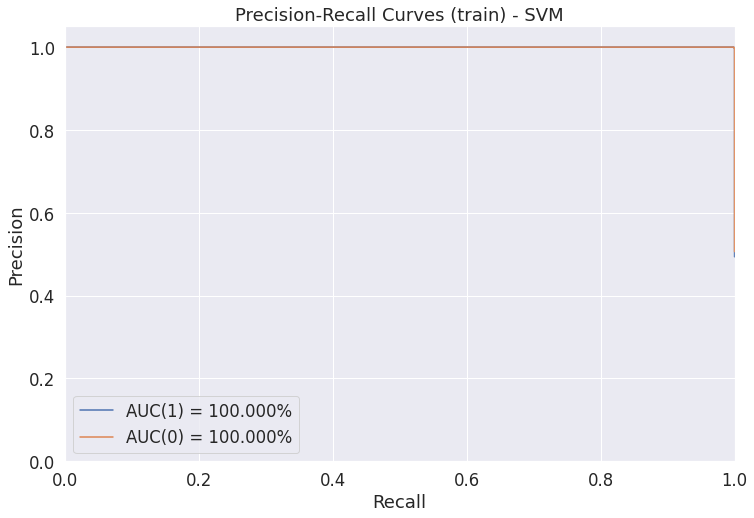

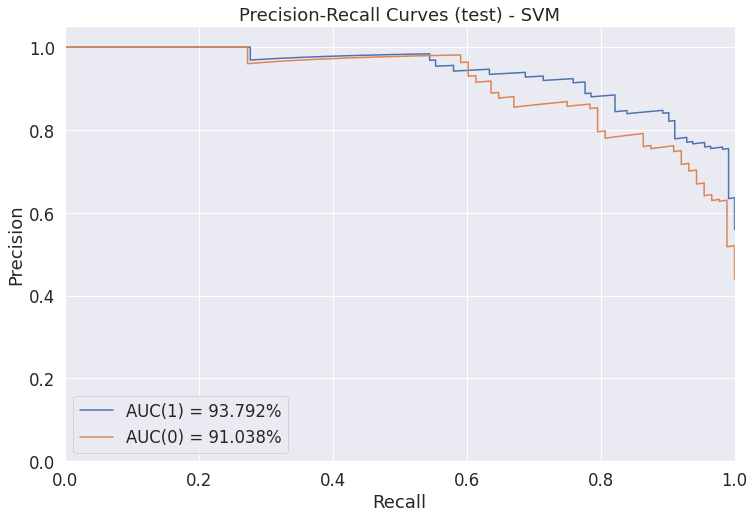

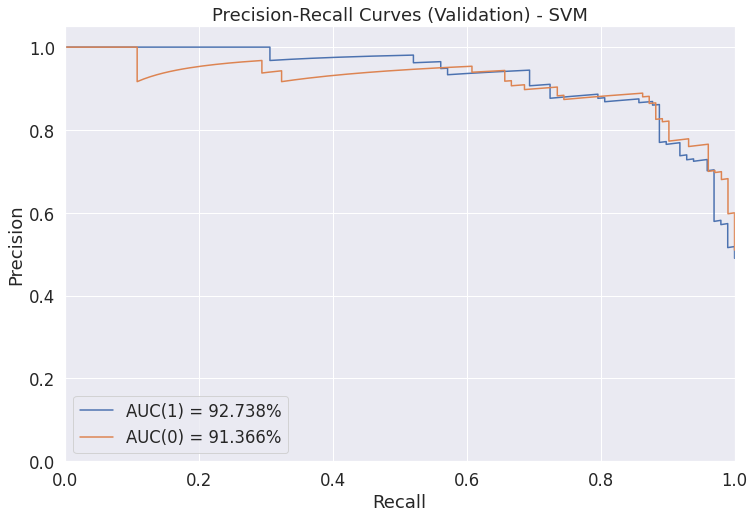

In [ ]:
# AUC scores
np.seterr(all='ignore')

estimators = {'SVM':svm_pipeline}
        
for (name,estimator) in estimators.items():
    model = estimator
    model.fit(docs_train, y_train)
    # We use the probabilities because the precision_recall_curve function needs them
    pred_train = model.predict_proba(docs_train)
    pred = model.predict_proba(docs_test)
    pred_val = model.predict_proba(docs_val)

    # model.predict() returns outputs of 0 or 1
    # model.predict_proba() returns an array: [P(x=0), P(x=1)]

    # Train Set
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, pred_train[:,1])
    precision1_train, recall1_train, thresholds1_train = precision_recall_curve(y_train, pred_train[:,0], pos_label=0)
    area_train = auc(recall_train, precision_train)
    area1_train = auc(recall1_train, precision1_train)
    plt.figure(figsize = (12,8))
    plt.plot(recall_train, precision_train, label=f'AUC(1) = {area_train:.3%}')
    plt.plot(recall1_train, precision1_train, label=f'AUC(0) = {area1_train:.3%}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves (train) - {name}')
    plt.legend(loc="lower left")
    plt.savefig(f'{name}_AUC_train.png')

    # Test Set
    precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, pred[:,0], pos_label=0)
    area = auc(recall, precision)
    area1 = auc(recall1, precision1)
    plt.figure(figsize = (12,8))
    plt.plot(recall, precision, label=f'AUC(1) = {area:.3%}')
    plt.plot(recall1, precision1, label=f'AUC(0) = {area1:.3%}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves (test) - {name}')
    plt.legend(loc="lower left")
    plt.savefig(f'{name}_AUC_test.png')

    # Validation Set
    precision, recall, thresholds = precision_recall_curve(y_val, pred_val[:,1])
    precision1, recall1, thresholds1 = precision_recall_curve(y_val, pred_val[:,0], pos_label=0)
    area = auc(recall, precision)
    area1 = auc(recall1, precision1)
    plt.figure(figsize = (12,8))
    plt.plot(recall, precision, label=f'AUC(1) = {area:.3%}')
    plt.plot(recall1, precision1, label=f'AUC(0) = {area1:.3%}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves (Validation) - {name}')
    plt.legend(loc="lower left")
    plt.savefig(f'{name}_AUC_Validation.png')

## MLP

### Further Data Preprocessing

In [ ]:
#Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, 
                             sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in 
                                          X_train_tokenized])
X_val_tfidf = vectorizer.transform([" ".join(x) for x in 
                                    X_val_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in 
                                    X_test_tokenized])
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)

(1600, 5000)
(200, 5000)
(200, 5000)


In [ ]:
# Reduce dimensionality using svd 5000 --> 500
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

Custom class that logs the f1-score, recall and precision of the validation dataset at the end of each epoch

In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)      
        

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, 
                                   val_predict, average='macro')
        _val_precision = precision_score(val_targ, 
                                         val_predict,average='macro')
        _val_accuracy = accuracy_score(val_targ, val_predict)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print("val_accuracy: %f — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_accuracy, _val_f1, _val_precision, _val_recall))
        return

Creating 1-hot vectors for y_train, t_test and y_val. This is not really necessary for this dataset as the classification labels are just two, but if we were to have more than two different classes, this would be necessary.

In [ ]:
y_train_1_hot = tf.keras.utils.to_categorical(y_train, 
                                              num_classes=len(movies.target_names))
y_val_1_hot = tf.keras.utils.to_categorical(y_val, 
                                            num_classes=len(movies.target_names))
y_test_1_hot = tf.keras.utils.to_categorical(y_test, 
                                             num_classes=len(movies.target_names))


for lidx,label in enumerate(movies.target_names):
  print("Index: {} Category: {}".format(lidx,label))
print("Label index: {} | 1-hot vector:  {}".format(y_train[0], 
                                                   y_train_1_hot[0]))
print("Label index: {} | 1-hot vector:  {}".format(y_train[10],
                                                   y_train_1_hot[10]))

Index: 0 Category: neg
Index: 1 Category: pos
Label index: 1 | 1-hot vector:  [0. 1.]
Label index: 0 | 1-hot vector:  [1. 0.]


Creating a function that will help us with the hyperparameter tuning of the MLP

In [ ]:
def model_builder(hp):
  
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)

  model.add(tf.keras.layers.Dense(units=hp_units,input_dim=X_train_svd.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))


  model.add(tf.keras.layers.Dense(len(movies.target_names), 
                                activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=hp_learning_rate
      ),
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

  return model

Setting the search parameters

In [ ]:
tuner = kt.RandomSearch(model_builder,
                        objective='val_categorical_accuracy',
                        max_trials=20)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', patience=5)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Creating the folder that will hold the checkpoints from the custom class we created before

In [ ]:
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/weights.hdf5',
                                                monitor='val_f1', 
                                                mode='max', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                save_weights_only=True)

Performing the search for the best hyperparameters

In [ ]:
tuner.search(X_train_svd, y_train_1_hot, epochs=100, 
             validation_data=(X_val_svd, y_val_1_hot), 
             callbacks=[early_stopping])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 00m 09s]
val_categorical_accuracy: 0.8700000047683716

Best val_categorical_accuracy So Far: 0.8849999904632568
Total elapsed time: 00h 02m 20s


Training an MLP using the best hyperparameters we found from the search above

In [ ]:
import keras.backend as K
model = tuner.hypermodel.build(best_hps)
print(model.summary())
history = model.fit(X_train_svd, y_train_1_hot, epochs=100, validation_data=(X_val_svd, y_val_1_hot),
                    callbacks=[Metrics(valid_data=(X_val_svd, y_val_1_hot)),
                         checkpoint])
eval_result = model.evaluate(X_test_svd, y_test_1_hot)
print("[test loss, test accuracy]:", eval_result)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 192)               96192     
                                                                 
 dropout_6 (Dropout)         (None, 192)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               49408     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 514       
                                                                 
Total params: 146,114
Trainable params: 146,114
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
7/7 [==========================

In [ ]:
print(f"The learning rate of the models is: {K.eval(model.optimizer.lr)}")

The learning rate of the models is: 0.0010000000474974513


Plotting the learning curves for the MLP

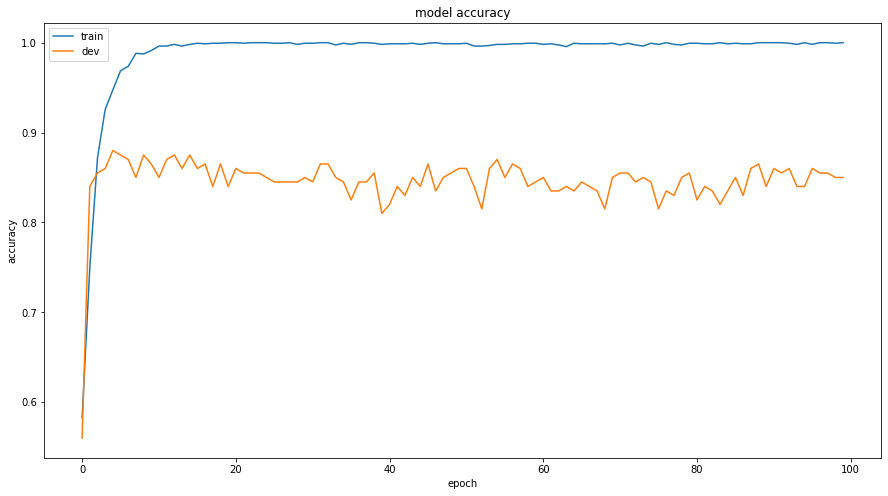

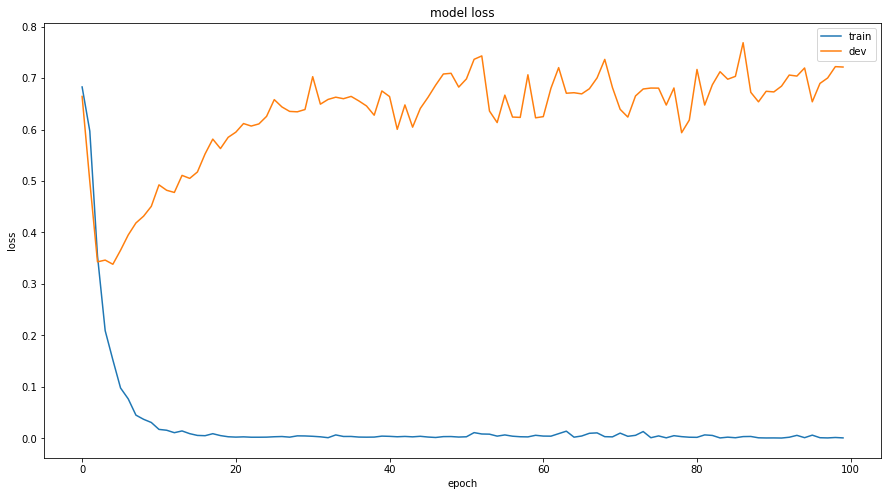

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig("acc_train.png")
#plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.savefig("loss_train.png")
#plt.show()

In [ ]:
# Classification Report for train set
predictions = np.argmax(model.predict(X_train_svd), -1)
print(classification_report(y_train, predictions, 
                            target_names=movies.target_names))

50/50 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       810
         pos       1.00      1.00      1.00       790

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [ ]:
# Classification Report for test set
predictions = np.argmax(model.predict(X_test_svd), -1)
print(classification_report(y_test, predictions, 
                            target_names=movies.target_names))

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         neg       0.83      0.85      0.84        88
         pos       0.88      0.87      0.87       112

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [ ]:
# Classification Report for validation set
predictions = np.argmax(model.predict(X_val_svd), -1)
print(classification_report(y_val, predictions, 
                            target_names=movies.target_names))

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         neg       0.83      0.88      0.86       102
         pos       0.87      0.82      0.84        98

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



7/7 [==============================] - 0s 3ms/step


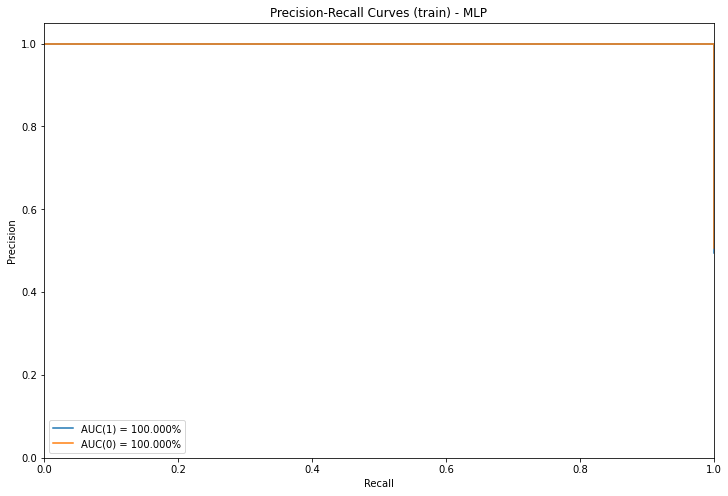

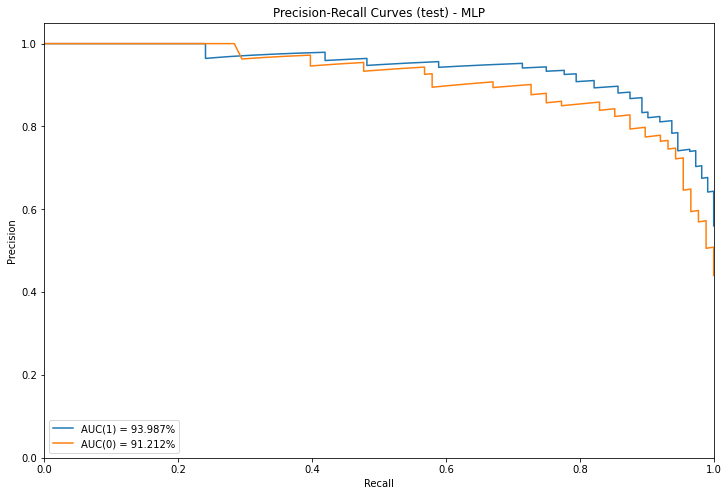

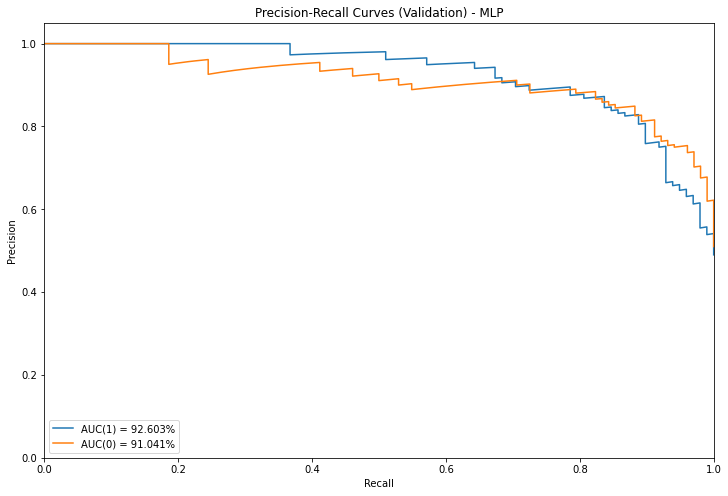

In [ ]:
# AUC scores for MLP
pred_train = model.predict(X_train_svd)
pred = model.predict(X_test_svd)
pred_val = model.predict(X_val_svd)

# Train Set
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, pred_train[:,1])
precision1_train, recall1_train, thresholds1_train = precision_recall_curve(y_train, pred_train[:,0], pos_label=0)
area_train = auc(recall_train, precision_train)
area1_train = auc(recall1_train, precision1_train)
plt.figure(figsize = (12,8))
plt.plot(recall_train, precision_train, label=f'AUC(1) = {area_train:.3%}')
plt.plot(recall1_train, precision1_train, label=f'AUC(0) = {area1_train:.3%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves (train) - MLP')
plt.legend(loc="lower left")
plt.savefig('MLP_AUC_train.png')

# Test Set
precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
precision1, recall1, thresholds1 = precision_recall_curve(y_test, pred[:,0], pos_label=0)
area = auc(recall, precision)
area1 = auc(recall1, precision1)
plt.figure(figsize = (12,8))
plt.plot(recall, precision, label=f'AUC(1) = {area:.3%}')
plt.plot(recall1, precision1, label=f'AUC(0) = {area1:.3%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves (test) - MLP')
plt.legend(loc="lower left")
plt.savefig('MLP_AUC_test.png')

# Validation Set
precision, recall, thresholds = precision_recall_curve(y_val, pred_val[:,1])
precision1, recall1, thresholds1 = precision_recall_curve(y_val, pred_val[:,0], pos_label=0)
area = auc(recall, precision)
area1 = auc(recall1, precision1)
plt.figure(figsize = (12,8))
plt.plot(recall, precision, label=f'AUC(1) = {area:.3%}')
plt.plot(recall1, precision1, label=f'AUC(0) = {area1:.3%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves (Validation) - MLP')
plt.legend(loc="lower left")
plt.savefig('MLP_AUC_Validation.png')